In [20]:
import csv
import json
import math
import re

import nltk
import numpy as np
import pandas as pd
from Index import Index
from matplotlib import pyplot as plt
from nltk.stem import PorterStemmer, WordNetLemmatizer
from rank_bm25 import BM25Okapi

# Predictions

In [2]:
index = Index(('index.json', 'inverted.json', 'queries.json', 'ground_truth.csv'), preprocessed=True)

## Vector

In [3]:
predicted_scalar = index.vector_search(max_docs=1460, metric='scalar') 
index.PR([[i[0] for i in j] for j in list(predicted_scalar.values())], index.relevent_docs)[2:] 

100%|██████████| 76/76 [01:37<00:00,  1.28s/it]


(0.028037130497476574, 0.9994801089185152)

In [4]:
with open('pred_scalar.json', 'w', encoding='utf-8') as f: 
    json.dump({str(k): v for k, v in predicted_scalar.items()}, f, ensure_ascii=False, indent=4) 

In [5]:
predicted_cos = index.vector_search(max_docs=1460, metric='cosine')
index.PR([[i[0] for i in j] for j in list(predicted_cos.values())], index.relevent_docs)[2:] 

100%|██████████| 76/76 [01:33<00:00,  1.22s/it]


(0.028037130497476574, 0.9994801089185152)

In [6]:
with open('pred_cos.json', 'w', encoding='utf-8') as f: 
    json.dump({str(k): v for k, v in predicted_cos.items()}, f, ensure_ascii=False, indent=4) 

In [7]:
predicted_jacc = index.vector_search(max_docs=1460, metric='jaccard') 
index.PR([[i[0] for i in j] for j in list(predicted_jacc.values())], index.relevent_docs)[2:] 

100%|██████████| 76/76 [02:35<00:00,  2.05s/it]


(0.028037130497476574, 0.9994801089185152)

In [8]:
with open('pred_jacc.json', 'w', encoding='utf-8') as f:
    json.dump({str(k): v for k, v in predicted_jacc.items()}, f, ensure_ascii=False, indent=4) 

## BM25

In [9]:
index = Index(('index.json', 'inverted.json', 'queries.json', 'ground_truth.csv'), preprocessed=True)

In [10]:
p = index.BM25() 
index.PR([[i[0] for i in j[:25]] for j in p], index.relevent_docs)[2:] 

100%|██████████| 76/76 [00:16<00:00,  4.57it/s]


(0.052105263157894745, 0.03607191392734016)

In [11]:
# Kaggle's
p = index.BM25_kapi()
index.PR([[i[0] for i in j[:50]] for j in p], index.relevent_docs)[2:] 

100%|██████████| 76/76 [00:00<00:00, 87.78it/s] 


(0.04078947368421053, 0.05698719375339137)

In [12]:
p = [[[str(i), l] for i, l in j] for j in p]
p = {str(i): j for i, j in enumerate(p)}

In [13]:
with open('pred_bm25.json', 'w', encoding='utf-8') as f:
    json.dump(p, f, ensure_ascii=False, indent=4)

## ROC

In [14]:
with open('pred_jacc.json') as f:
    pred_jacc = json.load(f)
with open('pred_cos.json') as f:
    pred_cos = json.load(f)
with open('pred_bm25.json') as f:
    pred_bm25 = json.load(f)
with open('pred_scalar.json') as f:
    pred_scalar = json.load(f) 
preds = [pred_scalar, pred_cos, pred_jacc, pred_bm25]

In [15]:
def precision(i, pred, relevent):
    pred = [[i[0] for i in j[:i]] for j in list(pred.values())]
    return index.PR(pred, index.relevent_docs)[2]

In [16]:
for pred in preds:
    print(precision(5, pred, index.relevent_docs)) 

0.05000000000000001
0.06315789473684211
0.05526315789473685
0.02631578947368421


In [17]:
for pred in preds:
    print(precision(10, pred, index.relevent_docs))

0.05394736842105264
0.06052631578947368
0.05921052631578947
0.025


In [25]:
def frange(x, y, jump):
    while x < y:
        yield x
        x += jump

def ROC(pred, relevent, step=11):
    PR = []
    for thresh in range(1, step):
        PR.append(index.PR([[i[0] for i in j[:thresh]] for j in list(pred.values())], relevent)[2:])
    PR = np.array(PR)
    roc = []
    recalls = list(frange(0, 1, 1/len(PR)))
    for r, pr in zip(recalls, PR):
        filtered = [i[0] for i in PR if i[1] >= r]
        p = max(filtered) if filtered else 0
        roc.append((p, r))
    return roc

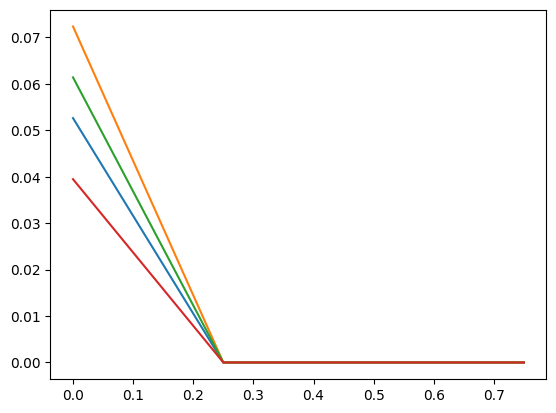

In [33]:
rocs = [] 
for pred in preds:
    rocs.append(np.array(ROC(pred, index.relevent_docs, 5))) 

for roc in rocs:
    plt.plot(roc[:, 1], roc[:, 0])
plt.show() 